In [1]:
!nvidia-smi

Mon Mar  7 08:17:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

DATA_DIR = "/content/drive/MyDrive/data"
CLASSES = os.listdir(DATA_DIR)
NUM_CLASSES = len(CLASSES)
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128
EPOCHS = 10

print(CLASSES)

['Common_Rust', 'Healthy', 'Blight', 'Gray_Leaf_Spot', 'resnet50(25']


In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=456,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    class_names=CLASSES
)

val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=456,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    class_names=CLASSES,
    shuffle = False
)

Found 4246 files belonging to 5 classes.
Using 3397 files for training.
Found 4246 files belonging to 5 classes.
Using 849 files for validation.


##Image sample

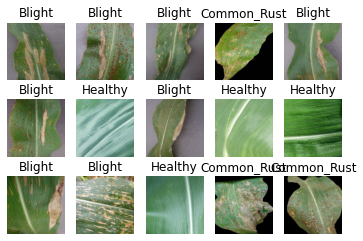

In [5]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(20, 10))
plt.figure()
for images, labels in train_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASSES[np.argmax(labels[i])])
        plt.axis("off")
plt.show()

#Transfer Learning Model

## ResNet50

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet import ResNet50, ResNet101, ResNet152
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization


resnet = ResNet50( weights="imagenet", include_top=False)
resnet.trainable = False

x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
resnet_predictions = Dense(len(CLASSES), activation='softmax')(x)

resnet_model = Model(inputs=resnet.input, outputs=resnet_predictions)

for layer in resnet.layers:
    layer.trainable = False

resnet_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=["accuracy"])

94781440/94765736 [==============================] - 1s 0us/step


In [7]:
history = resnet_model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
27/27 [==============================] - 266s 9s/step - loss: 0.4643 - accuracy: 0.8625 - val_loss: 0.0574 - val_accuracy: 0.9870
Epoch 2/10
27/27 [==============================] - 32s 1s/step - loss: 0.2001 - accuracy: 0.9273 - val_loss: 0.0099 - val_accuracy: 0.9976
Epoch 3/10
27/27 [==============================] - 32s 1s/step - loss: 0.1509 - accuracy: 0.9485 - val_loss: 0.0139 - val_accuracy: 0.9965
Epoch 4/10
27/27 [==============================] - 32s 1s/step - loss: 0.1164 - accuracy: 0.9582 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 5/10
27/27 [==============================] - 32s 1s/step - loss: 0.0892 - accuracy: 0.9709 - val_loss: 0.0061 - val_accuracy: 0.9976
Epoch 6/10
27/27 [==============================] - 32s 1s/step - loss: 0.0735 - accuracy: 0.9762 - val_loss: 0.0057 - val_accuracy: 0.9988
Epoch 7/10
27/27 [==============================] - 32s 1s/step - loss: 0.0628 - accuracy: 0.9770 - val_loss: 6.4599e-04 - val_accuracy: 1.0000
Epoch 8/10
27/2

In [8]:
resnet_model.save('/content/drive/MyDrive/data/resnet50(7/3/22).h5')

## History Plots

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=("Accuracy over time", "Loss over time"))

models = [resnet]
model_histories = [history]
model_names = ["ResNet"]

for i in range(0, len(models)):
    model = models[i]
    xepochs = [x for x in range(len(model_histories[i].history['loss']))]
    for metric in ['accuracy', 'val_accuracy']:
        fig.add_trace(go.Scatter(x=xepochs, y=model_histories[i].history[metric], mode='lines+markers', name=model_names[i] + " " + metric), row=1, col=1)

    for metric in ['loss', 'val_loss']:
        fig.add_trace(go.Scatter(x=xepochs, y=model_histories[i].history[metric], mode='lines+markers', name=model_names[i] + " " + metric), row=1, col=2)

fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_xaxes(title_text="Epoch", row=1, col=2)

fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=1, col=2)

fig.show()

## Confusion Matrices

In [10]:
from sklearn.metrics import confusion_matrix
import plotly.express as px


def plot_confusion_matrix(dataset, model):
    y_val = []
    y_val_pred = []

    for images, targets in dataset:
        for image, target in zip(images, targets):
            img_array = image.numpy().astype("uint8")
            prediction = model.predict(np.array([img_array]))
            y_val_pred.append(np.argmax(prediction))
            y_val.append(np.argmax(target))
    cm = confusion_matrix(y_val, y_val_pred)
    fig = px.imshow(
        cm,
        labels=dict(x="Predicted", y="Real"),
        x=CLASSES,
        y=CLASSES
    )
    fig.update_xaxes(side="top")
    fig.show()

## ResNet50

In [12]:
# plot_confusion_matrix(val_ds, resnet_model)

## Prediction

In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
model = load_model(r'C:\Users\Sahil\Desktop\IT\SEM 7\Final yr project\Main Code\model.h5')

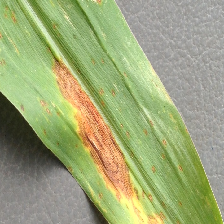

In [4]:
img=image.load_img(r'C:\Users\Sahil\Desktop\IT\SEM 7\Final yr project\Main Code\dataset\Blight\Corn_Blight (1137).jpg',target_size=(224,224))
img

In [5]:
x=image.img_to_array(img)
x

array([[[151., 182., 115.],
        [145., 176., 108.],
        [135., 168.,  99.],
        ...,
        [159., 159., 157.],
        [173., 173., 173.],
        [172., 172., 174.]],

       [[148., 183., 117.],
        [148., 181., 112.],
        [151., 184., 113.],
        ...,
        [159., 159., 157.],
        [161., 161., 161.],
        [162., 162., 164.]],

       [[163., 202., 135.],
        [139., 172., 101.],
        [143., 175., 100.],
        ...,
        [169., 169., 167.],
        [156., 158., 157.],
        [154., 156., 155.]],

       ...,

       [[155., 154., 150.],
        [172., 171., 167.],
        [145., 141., 138.],
        ...,
        [157., 183.,  47.],
        [158., 172.,  85.],
        [155., 159., 134.]],

       [[144., 143., 139.],
        [156., 155., 151.],
        [161., 157., 154.],
        ...,
        [155., 179.,  43.],
        [158., 177.,  70.],
        [227., 235., 196.]],

       [[146., 145., 141.],
        [149., 146., 141.],
        [147., 1

In [6]:
x.shape

(224, 224, 3)

In [7]:
#x=x/255
x = x.reshape(1,224,224,3)

In [30]:
# from tensorflow.keras.applications.inception_v3 import preprocess_input
# import numpy as np
# x=np.expand_dims(x,axis=0)
# img_data=preprocess_input(x)
# img_data.reshape(1,224,224,3)
# img_data.shape

In [8]:
preds = model.predict(x)
preds

array([[4.589661e-08, 3.723826e-07, 9.996766e-01, 3.143434e-04,
        8.741626e-06]], dtype=float32)

In [9]:
import numpy as np
preds = np.argmax(preds,axis=1)
preds

array([2], dtype=int64)

In [10]:
CLASSES

NameError: name 'CLASSES' is not defined

In [11]:
if preds == 0:
   print ("The leaf is diseased with Common Rust")
elif preds == 1:
   print ("The leaf is healthy")
elif preds == 2:
   print ("The leaft is Blight")
else:
   print ("The Leaf has the disease of Gray leaf spot")


The leaft is Blight
